# Rejection-based EEG Signal Classification

## Import Libraries

In [97]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014_001, BNCI2014_004, Cho2017
from moabb.evaluations import CrossSessionEvaluation, CrossSubjectEvaluation, WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

import pyriemann

import numpy as np


moabb.set_log_level("info")
warnings.filterwarnings("ignore")

## Instantiate a Dataset

In [73]:
dataset = BNCI2014_001()
dataset.subject_list = [1]

## Access EEG Recordings

An example of recordings based on two subjects.

In [ ]:
sessions = dataset.get_data(subjects=[1, 2])

In [19]:
sessions

{1: {'0train': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>},
  '1test': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>}},
 2: {'0train': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 

## Choose a Paradigm

In [4]:
print(dataset.paradigm)

imagery


In [91]:
paradigm = LeftRightImagery()

In [92]:
paradigm.datasets

## Unpack the Dataset

In [38]:
X, labels, meta = paradigm.get_data(dataset=dataset)

In [47]:
print(X.shape, type(X))

(2592, 22, 1001) <class 'numpy.ndarray'>


In [48]:
print(labels, "\n", type(labels))
print("The number of labels:", len(labels))

['right_hand' 'left_hand' 'left_hand' ... 'left_hand' 'right_hand'
 'left_hand'] 
 <class 'numpy.ndarray'>
The number of labels: 2592


In [49]:
print(meta)

      subject session run
0           1  0train   0
1           1  0train   0
2           1  0train   0
3           1  0train   0
4           1  0train   0
...       ...     ...  ..
2587        9   1test   5
2588        9   1test   5
2589        9   1test   5
2590        9   1test   5
2591        9   1test   5

[2592 rows x 3 columns]


In [51]:
print(np.unique(meta["session"]))

['0train' '1test']


## Create a Pipeline

In [62]:
pipeline = make_pipeline(CSP(n_components=8), LogisticRegression())

## Evaluate a Solution

In [108]:
datasets_mi = [BNCI2014_001(), BNCI2014_004(), Cho2017()]

In [109]:
evaluation = CrossSubjectEvaluation(
    paradigm=paradigm,
    datasets=datasets_mi,
    overwrite=True,
    hdf5_path=None,
)

In [110]:
results = evaluation.process({"csp+lr": pipeline})

2024-04-02 18:59:00,158 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSubject:   0%|          | 0/9 [00:05<?, ?it/s]


TypeError: _score() missing 1 required positional argument: 'score_params'

In [65]:
results.to_csv("./results_test.csv")

In [66]:
results = pd.read_csv("./results_test.csv")

## Plot the Results

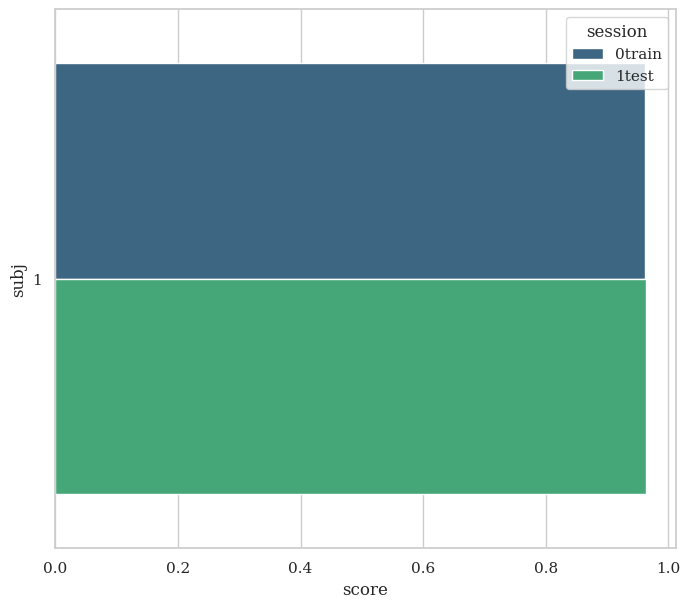

In [78]:
fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
plt.show()

## Split the Data

In [ ]:
train_sessions = meta[meta["session"] == "0train"]
test_sessions = meta[meta["session"] == "1test"]

In [ ]:
X_train = X[train_sessions.index]
X_test = X[test_sessions.index]

y_train = labels[train_sessions.index]
y_test = labels[test_sessions.index]

## Define a Range of Sample Sizes

In [54]:
min_sample_size = 50
max_sample_size = len(X_train)
step_size = 50

sample_sizes = np.arange(min_sample_size, max_sample_size + step_size, step_size)

## Train a Model

In [56]:
accuracies = []
for size in sample_sizes:
    # Randomly select a subset of the training data.
    indices = np.random.choice(len(X_train), size=size, replace=False)
    X_subset = X_train[indices]
    y_subset = y_train[indices]
    
    # Train a logistic regression model.
    evaluation = WithinSessionEvaluation(paradigm=paradigm,
                                         datasets=[dataset],
                                         overwrite=True,
                                         hdf5_path=None,
                                         )
    
    # Make predictions on the test set.
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and store it.
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

ValueError: Found array with dim 3. LogisticRegression expected <= 2.